## Automatic simulation

In this simulation we go directly from the patient coordinates to the MRI coordinates

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random


In [21]:
from end_utils import create_transform, \
                                  multiply_points_by_matrix, \
                                  multiply_point_by_matrix, pointer_to_mri,\
                                  camera_to_mri, mri_to_camera, add_noise_to_points,\
                                  add_noise_to_params, extract_rigid_body_parameters,\
                                  rigid_body_parameters_to_matrix, \
                                  convert_4x1_to_1x1x3, project_camera_point_to_image, \
                                  create_pnt_ref, create_pnt_ref_in_camera_space, create_pat_ref, \
                                  create_pat_ref_in_camera_space, get_ref_T_tip, calculate_euclid_dist, convert_points_nx3_to_1xnx3


In [22]:
# creating 4 points in patient coordinates

z = 200 # head length (about 20cm)
x = 250 # menton to top of head (about 25cm)
y = 150 # head bredth (about 15cm)


points = np.array(
[
    [-x,-y,z],
    [-x,y,z],
    [x,y,z],
    [x,-y,z],
])


cancer_point = convert_points_nx3_to_1xnx3(np.array([[0,0,0]]))

#points_converted = convert_points_nx3_to_1xnx3(points)


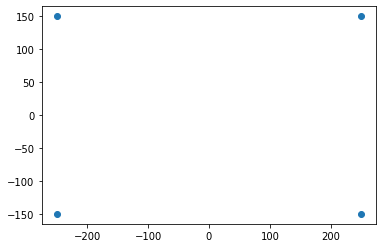

In [23]:
plt.figure()
plt.scatter(points[:,0], points[:,1])
plt.show()

## projecting points from 3D to 2D

In [24]:
intrinsics = np.loadtxt('calibration/intrinsics.txt')
distortion = np.loadtxt('calibration/distortion.txt')

print("Intrinsics are:" + str(intrinsics))
print("Distortion coefficients are:" + str(distortion))


Intrinsics are:[[664.6329766    0.         931.53151205]
 [  0.         663.83211807 520.64004697]
 [  0.           0.           1.        ]]
Distortion coefficients are:[-4.0929449e-01  2.1631278e-01  1.1120000e-05  1.2712000e-03
 -7.2057120e-02]


In [25]:
points_converted = convert_points_nx3_to_1xnx3(points)

rvec = np.zeros((1,3))
tvec = np.zeros((1,3))
image_points, jacobian = cv2.projectPoints(points_converted, rvec, tvec, intrinsics, distortion)

In [26]:
image_points = image_points.squeeze()
print(image_points)

[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]


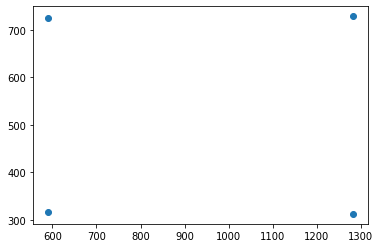

In [27]:
plt.figure()
plt.scatter(image_points[:,0], image_points[:,1])
plt.show()

# Simulation 1: adding noise to image points (2D)

First we add noise to the image points (that is- add noise in 2D)

In [28]:
image_points_noisy = add_noise_to_points(image_points,0.25)

We then find the corresponding transformation to get us from the 3D image points to the corresponding noisy image points

In [29]:
success_true, rotation_vector_true, translation_vector_true = cv2.solvePnP(points.astype('float32'), image_points.astype('float32'), intrinsics, distortion, flags=0 )

success, rotation_vector, translation_vector = cv2.solvePnP(points.astype('float32'), image_points_noisy.astype('float32'), intrinsics, distortion, flags=0 )

if success_true:
    print(f'rotation true:, {rotation_vector_true}')
    print(f'translation true:, {translation_vector_true}')
else:
    print('solution not found')
    
if success:
    print(f'rotation:, {rotation_vector}')
    print(f'translation:, {translation_vector}')
else:
    print('solution not found')
    

        

rotation true:, [[-1.33849327e-04]
 [ 1.53026096e-02]
 [ 2.27516157e-07]]
translation true:, [[-2.08313803e+00]
 [-1.82287484e-02]
 [ 2.01168074e+02]]
rotation:, [[-0.00045071]
 [ 0.01786254]
 [-0.0006436 ]]
translation:, [[-2.88688192e+00]
 [ 5.64466665e-02]
 [ 2.00853906e+02]]


Finally we project the 3D points to 2D with the true and noisy rotation and translation

In [30]:
point_projected2D_true, jacobian = cv2.projectPoints(points_converted, rotation_vector_true, translation_vector_true, intrinsics, distortion)
point_projected2D_true = point_projected2D_true.squeeze()
print(point_projected2D_true)

point_projected2D, jacobian = cv2.projectPoints(points_converted, rotation_vector, translation_vector, intrinsics, distortion)
point_projected2D = point_projected2D.squeeze()
print(point_projected2D)



[[ 590.71083943  315.32212628]
 [ 590.68341083  726.00576517]
 [1281.25122558  729.16991962]
 [1281.22322562  312.15831522]]
[[ 590.46930238  315.89627778]
 [ 590.69900141  726.25251792]
 [1281.65085846  729.54468163]
 [1281.34649043  311.719114  ]]


We can also use this rotation and translation to transform any other point in this coordinate system- eg. a point where the caner is locaed


In [31]:
cancer_projected2D_true, jacobian = cv2.projectPoints(cancer_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
cancer_projected2D_true = cancer_projected2D_true.squeeze()
print(cancer_projected2D_true)

cancer_projected2D, jacobian = cv2.projectPoints(cancer_point, rotation_vector, translation_vector, intrinsics, distortion)
cancer_projected2D = cancer_projected2D.squeeze()
print(cancer_projected2D)


[924.64967063 520.57989916]
[921.98004498 520.82658493]


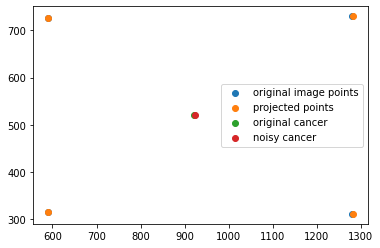

In [33]:
plt.figure()
plt.scatter(image_points[:,0], image_points[:,1])
plt.scatter(point_projected2D[:,0], point_projected2D[:,1])
#plt.scatter(image_points_noisy[:,0], image_points_noisy[:,1])

plt.scatter(cancer_projected2D[0], cancer_projected2D[1])
plt.scatter(cancer_projected2D_true[0], cancer_projected2D_true[1])

plt.legend(['original image points', 'projected points', 'original cancer', 'noisy cancer'])

plt.show()

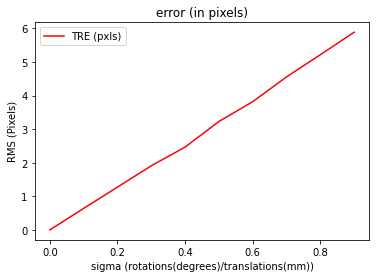

In [34]:

number_samples = 1000
x_values_px = []
y_values_px = []

x_values_mm = []
y_values_mm = []

for sigma_counter in range(0, 10, 1):
    sigma = float(sigma_counter) / float(10)
    rms = 0
    for i in range(number_samples):
        
        # add noise to image points
        image_points_noisy = add_noise_to_points(image_points,sigma)
        
        # try and match noisy 2D to original 3d object points
        # true
        success_true, rotation_vector_true, translation_vector_true = cv2.solvePnP(points.astype('float32'), image_points.astype('float32'), intrinsics,distortion, flags=0 )
        # noisy
        success, rotation_vector, translation_vector = cv2.solvePnP(points.astype('float32'), image_points_noisy.astype('float32'), intrinsics,distortion, flags=0 )

        
        # project cancer 3D point using the found rotations and translations
        # true
        point_projected2D_true, _ = cv2.projectPoints(cancer_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
        point_projected2D_true = point_projected2D_true.squeeze()
        # noisy
        point_projected2D, _ = cv2.projectPoints(cancer_point, rotation_vector, translation_vector, intrinsics, distortion)
        point_projected2D = point_projected2D.squeeze()

        
        
        euclid_dist_px =  (point_projected2D_true[0] - point_projected2D[0]) \
                     * (point_projected2D_true[0] - point_projected2D[0]) \
                     + (point_projected2D_true[1] - point_projected2D[1]) \
                     * (point_projected2D_true[1] - point_projected2D[1]) 
        
        #euclid_dist_mm = calculate_euclid_dist()
        
        rms = rms + euclid_dist_px
        
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    x_values_px.append(sigma)
    y_values_px.append(rms)
    
plt.plot(x_values_px, y_values_px, 'r', label='TRE (pxls)')
plt.title('error (in pixels)')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('RMS (Pixels)')
plt.show()


## Simulation 2: adding noise to 3D


In [ ]:
noisy_points = add_noise_to_points(points, 0.5)

plt.figure()
plt.scatter(points[:,0], points[:,1])
plt.scatter(noisy_points[:,0], noisy_points[:,1])
plt.show()


## Simulation 3: adding noise to both